In [1]:
import numpy as np
import scipy.linalg as linalg
from matplotlib import pyplot as plt
from scipy.linalg import svd

from ssa_methods.ssa_classic import SSA_classic

import pandas as pd

# auxilaty plotting functions
from ssa_methods.ssa_complementary.plotting import *
# partition finding algorithms
from ssa_methods.ssa_complementary.ssa_classic_partition import *

%matplotlib inline 
plt.rcParams.update({'font.size': 13})

### Build synthetic signal

(<Figure size 1200x500 with 1 Axes>,
 <Axes: title={'center': 'Synthetic'}, xlabel='$t$', ylabel='$y$'>)

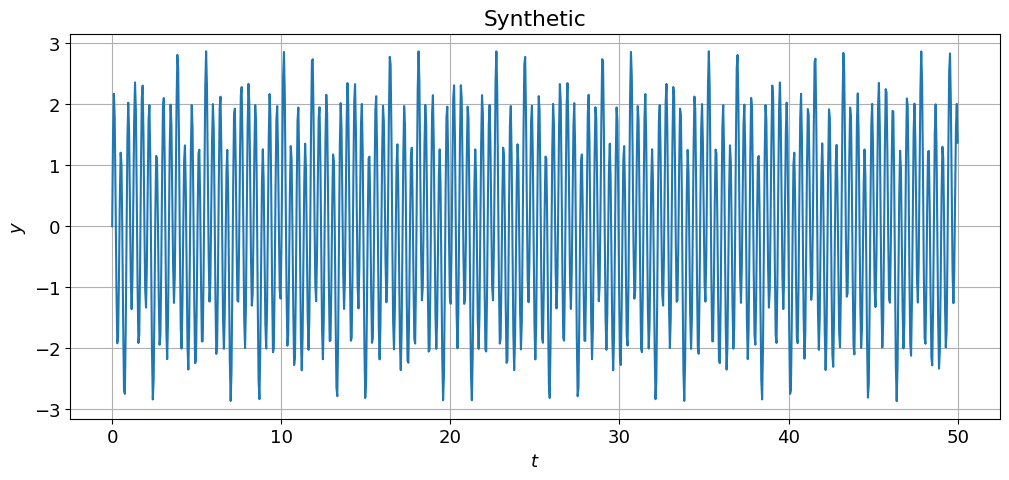

In [2]:
# size of the signal
grid_size = 1000
# end time point
grid_end = 50

time_grid = np.linspace(0, grid_end, grid_size)
signal = np.sin(2 * time_grid) * np.cos(5 * time_grid) + 2 * np.sin(15 * time_grid)

plot_signal(time_grid, signal, sig_name='Synthetic', figsize=(12, 5))

### Initiate SSA object

In [3]:
# ssa parameter - window size
L = 80

ssa_obj = SSA_classic(signal, L)
# build and make svd for trajectory matrix
ssa_obj.decompose_tm()

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Available singular values of trajectory matrix'}, xlabel='Singular value number', ylabel='$\\sigma$'>)

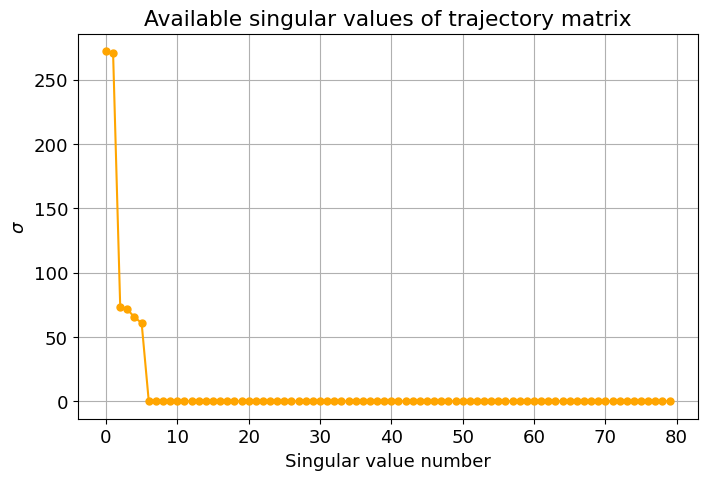

In [4]:
# have a look at singular values
plot_singular_values(ssa_obj.weights, figsize=(8, 5))

In [5]:
# let's remove some of them
ssa_obj.dispose_factors(np.arange(6, len(ssa_obj.weights)))

# check sizes correctness
print(len(ssa_obj.weights))
print(ssa_obj._left_factors.shape[1])
print(ssa_obj._right_factors.shape[0])

6
6
6


(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Available singular values of trajectory matrix'}, xlabel='Singular value number', ylabel='$\\sigma$'>)

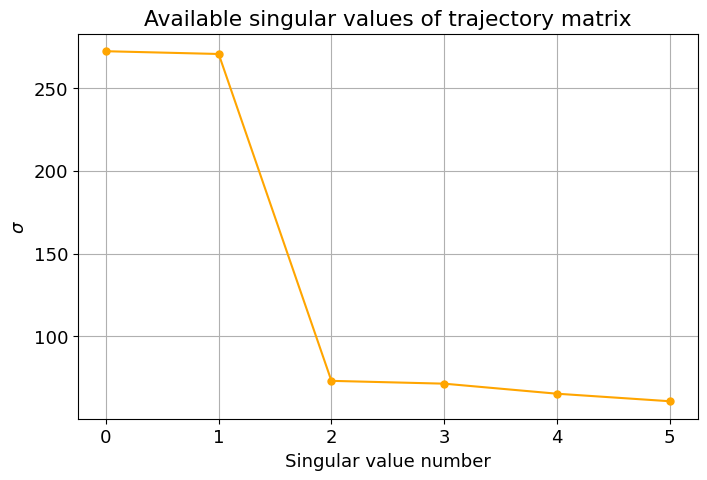

In [6]:
plot_singular_values(ssa_obj.weights, figsize=(8, 5))

### Decomposition

In [7]:
# from the ssa_methods.ssa_complementary.ssa_classic_partition obtain global variables
global _best_found_grouping
global _best_integral_hankel_resid

#### Based on singular values

In [8]:
# try decomposition based on singular values plot
sing_val_grouping = [[0, 1], [2, 3], [4, 5]]
ssa_obj.set_factors_grouping(sing_val_grouping)
components, resids_abs, resids_rel = ssa_obj.decompose_signal()

In [9]:
# print residuals info
print(f'Absolute residual values: {resids_abs}\nMean absolute residual = {np.mean(resids_abs)}')
print(f'Relative residual values: {resids_rel}\nMean reletive residual = {np.mean(resids_rel)}')

Absolute residual values: [ 5.42719269 66.9892807  66.93920135]
Mean absolute residual = 46.451891581217446
Relative residual values: [0.01413681 0.65546754 0.74994277]
Mean reletive residual = 0.47318237444447203


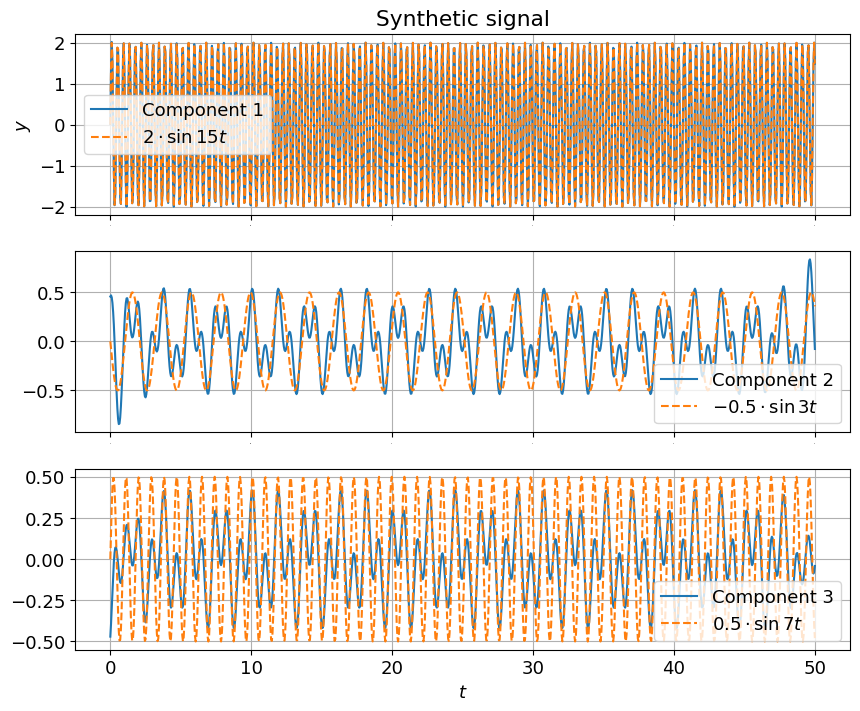

In [10]:
# plot decomposition
fig, axs = plot_component_signals(time_grid, components, 'Synthetic', figsize=(10, 8))

axs[0].plot(time_grid, 2 * np.sin(15 * time_grid), label='$2 \\cdot \\sin 15t$', linestyle='--')
axs[0].legend()

axs[1].plot(time_grid, -0.5 * np.sin(3 * time_grid), label='$-0.5 \\cdot \\sin 3t$', linestyle='--')
axs[1].legend()

axs[2].plot(time_grid, 0.5 * np.sin(7 * time_grid), label='$0.5 \\cdot \\sin 7t$', linestyle='--')
axs[2].legend()

#### Based on discrete optimization

In [11]:
# trying full search. Too long!
ssa_obj.set_factors_grouping([])
# full_search_partitioning(ssa_obj)

print(f'Cur best partition score = {get_best_integral_hankel_resid()}')
print(f'Cur best grouping = {get_best_found_grouping()}')

Cur best partition score = 1000000000000000.0
Cur best grouping = []


In [12]:
# trying local search from the singuar value approximation
ssa_obj.set_factors_grouping([])
local_search_partitioning(ssa_obj, sing_val_grouping, 3)

print(f'Cur best partition score = {get_best_integral_hankel_resid()}')
print(f'Cur best grouping = {get_best_found_grouping()}')

Cur best partition score = 5.427192687988281
Cur best grouping = [[0, 1], [2, 3, 4, 5]]


In [13]:
ssa_obj.set_factors_grouping(get_best_found_grouping())
components, resids_abs, resids_rel = ssa_obj.decompose_signal()

# print residuals info
print(f'Absolute residual values: {resids_abs}\nMean absolute residual = {np.mean(resids_abs)}')
print(f'Relative residual values: {resids_rel}\nMean reletive residual = {np.mean(resids_rel)}')

Absolute residual values: [5.42719269 5.42719269]
Mean absolute residual = 5.427192687988281
Relative residual values: [0.01413681 0.03999656]
Mean reletive residual = 0.027066684784531204


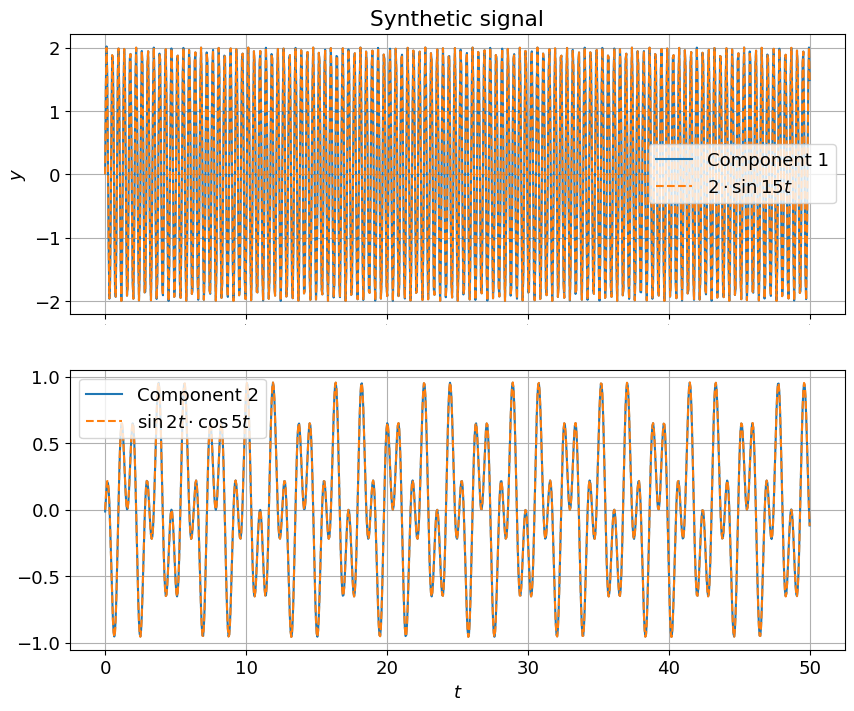

In [14]:
# plot decomposition
fig, axs = plot_component_signals(time_grid, components, 'Synthetic', figsize=(10, 8))

axs[0].plot(time_grid, 2 * np.sin(15 * time_grid), label='$2 \\cdot \\sin 15t$', linestyle='--')
axs[0].legend()

axs[1].plot(time_grid, np.sin(2 * time_grid) * np.cos(5 * time_grid), label='$\\sin2t \\cdot \\cos 5t$', linestyle='--')
axs[1].legend()

### Prediction

In [15]:
# test methods
print(ssa_obj.get_prediction())
ssa_obj.remove_last_prediction(1)

[]


ValueError: Deleting more values then available.

Current prediction = [-0.01835318]
Current prediction = [-0.01835318 -1.44750379]
Current prediction = [-0.01835318 -1.44750379 -2.1663657 ]
Current prediction = [-0.01835318 -1.44750379 -2.1663657  -1.78346026]
Current prediction = [-0.01835318 -1.44750379 -2.1663657  -1.78346026 -0.48337203]


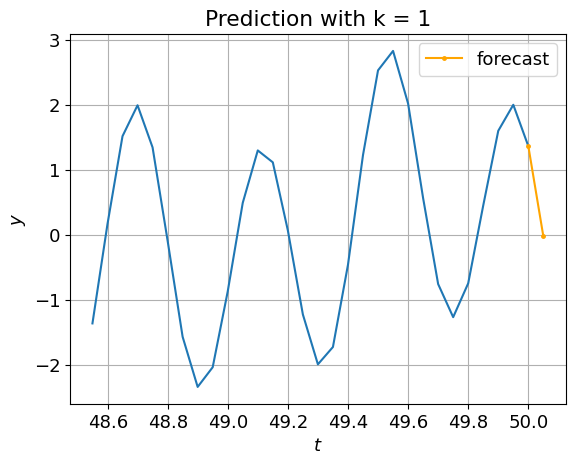

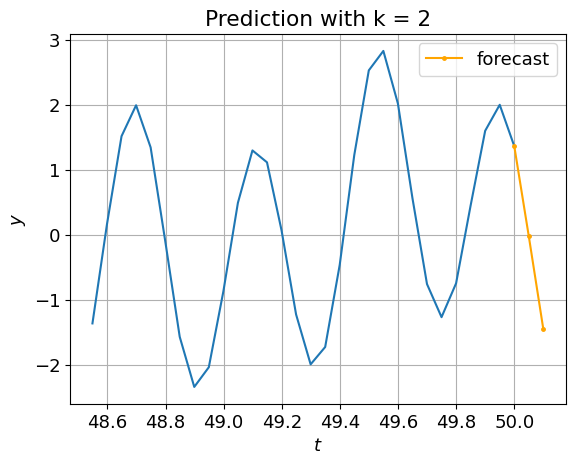

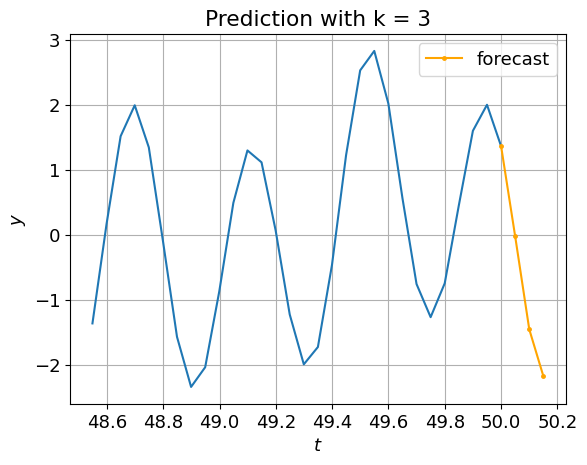

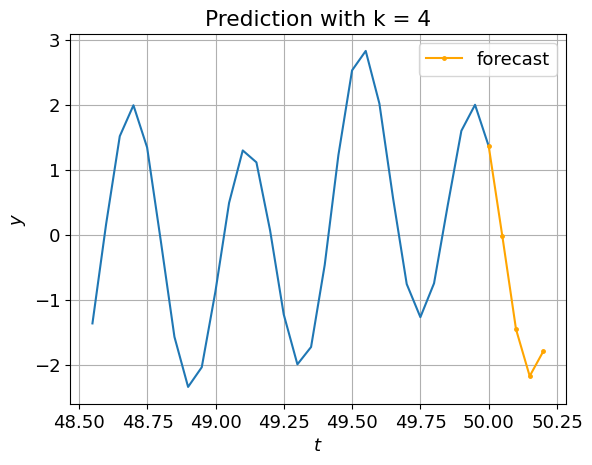

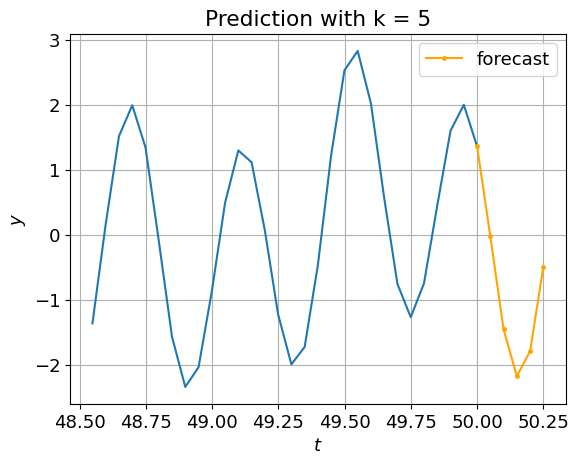

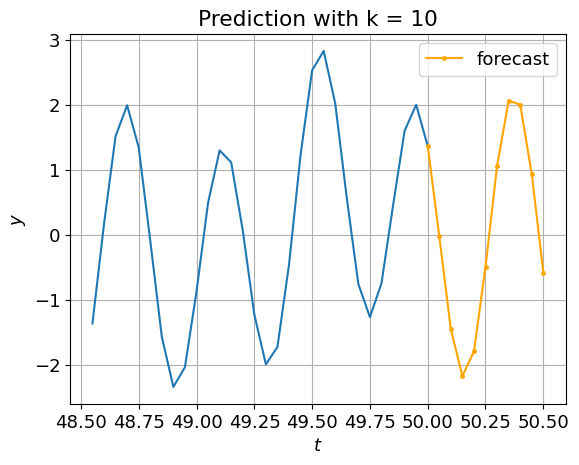

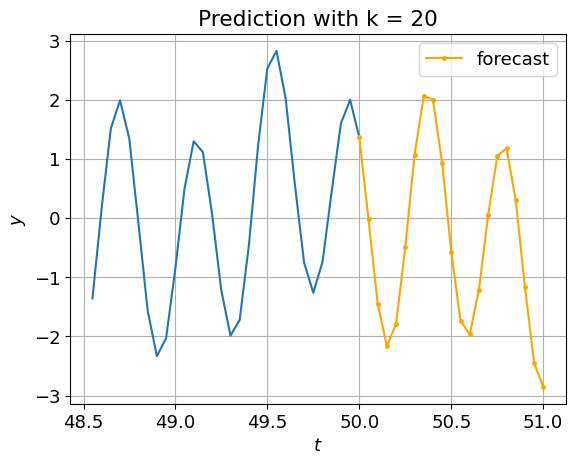

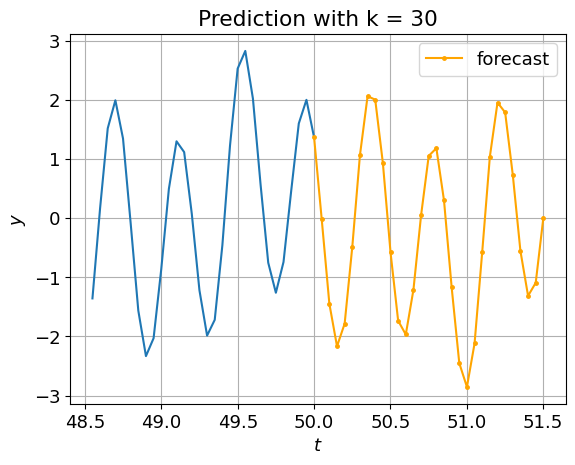

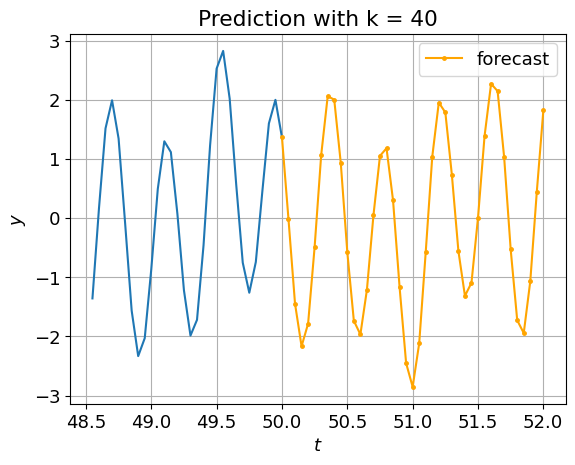

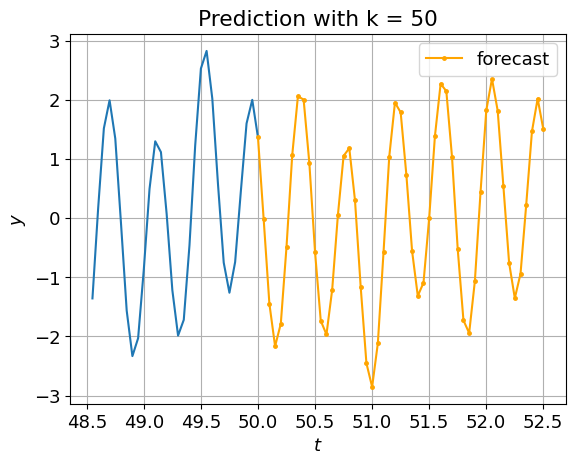

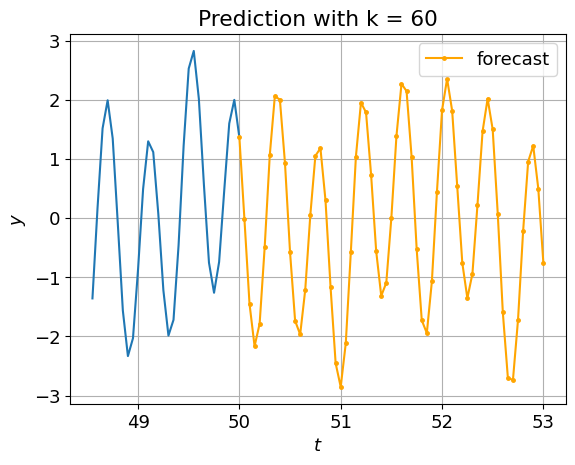

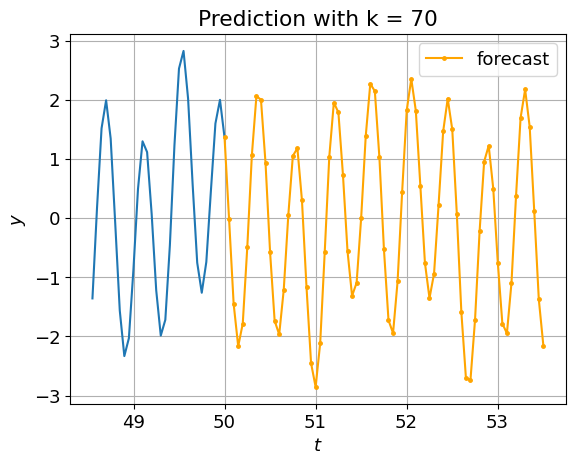

In [21]:
ssa_obj.remove_last_prediction()

last_known_values_edge = 30
last_known_values = ssa_obj.t_s[-last_known_values_edge:]
last_values_time_grid = time_grid[-last_known_values_edge:]

# obtaining predictions for diffrent horizions from last known point
for k in range(1, ssa_obj.L - len(ssa_obj.weights)):
    try:
        cur_prediction = ssa_obj.predict_next(k)
    except Exception as ex:
        print(ex.args)
        continue

    if k % 10 == 0 or (k >= 1 and k <= 5):
        time_grid_extension = np.linspace(time_grid[-1], time_grid[-1] + k * time_grid[1], k + 1)
        t_s_extension = np.concatenate([np.array([ssa_obj.t_s[-1]]), cur_prediction], axis=0)
    
        if k >= 1 and k <= 5:
            print(f'Current prediction = {cur_prediction}')

        _, ax = plot_signal(last_values_time_grid, last_known_values, sig_name=f'Prediction with k = {k}')
        ax.plot(time_grid_extension, t_s_extension, color='orange', marker='.', ms=5, label='forecast')
        ax.legend()

    ssa_obj.remove_last_prediction(k)

Few first predictions: [-0.018353176253733727, -1.4475037856423556, -2.1663657015146587, -1.783460262855777, -0.48337203395227935, 1.0662212325659572]


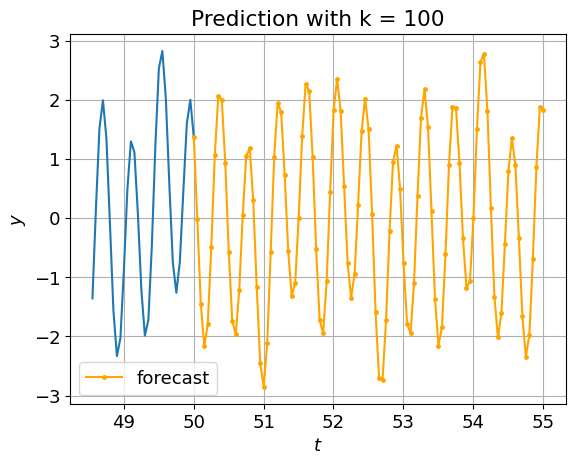

In [25]:
ssa_obj.remove_last_prediction()
# get prediction by one step for some horizon
cur_horizon = 100
for i in range(cur_horizon):
    try:
        ssa_obj.predict_next(1)
    except Exception as ex:
        break

time_grid_extension = np.linspace(time_grid[-1], time_grid[-1] + len(ssa_obj.get_prediction()) * time_grid[1], cur_horizon + 1)
t_s_extension = np.concatenate([np.array([ssa_obj.t_s[-1]]), ssa_obj.get_prediction()], axis=0)

_, ax = plot_signal(last_values_time_grid, last_known_values, sig_name=f'Prediction with k = {cur_horizon}')
ax.plot(time_grid_extension, t_s_extension, color='orange', marker='.', ms=5, label='forecast')
ax.legend()

print(f'Few first predictions: {ssa_obj.get_prediction()[:6]}')